# CNN with class

## 0.import module

In [1]:
# 패키지 import
import glob
import os.path as osp
import random
import numpy as np
import json
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision
from torchvision import models, transforms


In [2]:
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  1.13.0
Torchvision Version:  0.14.0


## 1.download model(net)

In [3]:
net = models.vgg16(pretrained = True)
print(net)

c:\Users\default.DESKTOP-HUJV032\anaconda3\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\default.DESKTOP-HUJV032\anaconda3\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

## 2.transform 클래스

In [4]:
class BaseTransform():
    """
    화상의 크기를 리사이즈하고 색상을 표준화한다.

    Attributes
    ----------
    resize : int
        리사이즈 대상 이미지의 크기.
    mean : (R, G, B)
        각 색상 채널의 평균 값.
    std : (R, G, B)
        각 색상 채널의 표준 편차.
    """

    def __init__(self, resize, mean, std): # Class를 정의? 할 때 resize, mean, std를 입력해줘야 함
        self.base_transform = {
            'train' : transforms.Compose([
            transforms.RandomResizedCrop(resize, scale = (0.5, 1.0)), # 0.5 ~ 1.0 -> 면적 비율 50 ~ 100%로 자르기
            transforms.Resize(resize),  # 짧은 변의 길이가 resize의 크기가 된다
            transforms.CenterCrop(resize),  # 이미지 중앙을 resize × resize으로 자르기
            transforms.ToTensor(),  # Torch 텐서로 변환
            transforms.Normalize(mean, std)  # 색상 정보의 표준화
        ]),
        'val' : transforms.Compose([
            transforms.Resize(resize),  # 짧은 변의 길이가 resize의 크기가 된다
            transforms.CenterCrop(resize),  # 이미지 중앙을 resize × resize으로 자르기
            transforms.ToTensor(),  # Torch 텐서로 변환
            transforms.Normalize(mean, std)  # 색상 정보의 표준화
        ])
        }

    def __call__(self, img,phase = 'train'): # BaseTransform() 클래스를 호출하면 바로 실햄됨 # 추가적인 함수를 사용할 필요 없음 # 기본값은 train
        return self.base_transform[phase](img)


In [5]:
%cd C:/Users/default.DESKTOP-HUJV032/DL_data

C:\Users\default.DESKTOP-HUJV032\DL_data


In [6]:
ori_img = Image.open('goldenretriever-3724972_640.jpg')

In [7]:
resize = 224
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
test_transform = BaseTransform(resize, mean, std)

In [8]:
transform_img = test_transform(ori_img) # shape: [3, 224, 224]
transform_img.shape

torch.Size([3, 224, 224])

In [9]:
# (c , h ,w) -> (h, w, c) 
transform_img = transform_img.numpy().transpose((1,2,0))
# 값을 0 - 1사이로
transform_img = np.clip(transform_img,0,1)

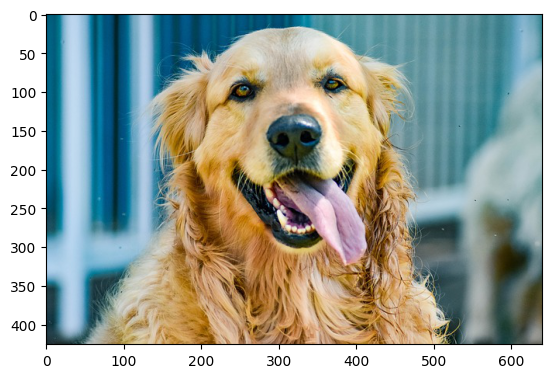

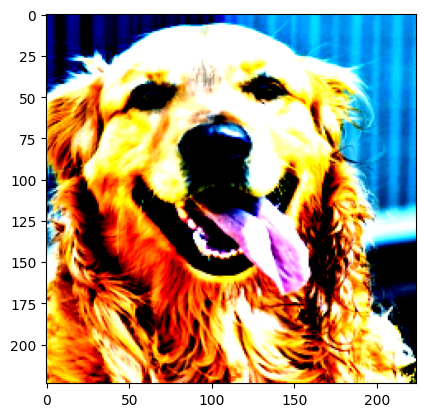

In [10]:
# before transform
plt.imshow(ori_img)
plt.show()
# after transform
plt.imshow(transform_img)
plt.show()

## 3.후처리 클래스
- 출력 결과로 라벨명으로 변경

### class 구현 전 함수 뜯어보기

In [11]:
# 결과값들의 index와 이름이 담겨있는 json파일
class_index = json.load(open('imagenet_class_index.json','r'))
class_index

{'0': ['n01440764', 'tench'],
 '1': ['n01443537', 'goldfish'],
 '2': ['n01484850', 'great_white_shark'],
 '3': ['n01491361', 'tiger_shark'],
 '4': ['n01494475', 'hammerhead'],
 '5': ['n01496331', 'electric_ray'],
 '6': ['n01498041', 'stingray'],
 '7': ['n01514668', 'cock'],
 '8': ['n01514859', 'hen'],
 '9': ['n01518878', 'ostrich'],
 '10': ['n01530575', 'brambling'],
 '11': ['n01531178', 'goldfinch'],
 '12': ['n01532829', 'house_finch'],
 '13': ['n01534433', 'junco'],
 '14': ['n01537544', 'indigo_bunting'],
 '15': ['n01558993', 'robin'],
 '16': ['n01560419', 'bulbul'],
 '17': ['n01580077', 'jay'],
 '18': ['n01582220', 'magpie'],
 '19': ['n01592084', 'chickadee'],
 '20': ['n01601694', 'water_ouzel'],
 '21': ['n01608432', 'kite'],
 '22': ['n01614925', 'bald_eagle'],
 '23': ['n01616318', 'vulture'],
 '24': ['n01622779', 'great_grey_owl'],
 '25': ['n01629819', 'European_fire_salamander'],
 '26': ['n01630670', 'common_newt'],
 '27': ['n01631663', 'eft'],
 '28': ['n01632458', 'spotted_salama

In [12]:
# model에 넣을 수 있도록 데이터 변형
transform_img = test_transform(ori_img)
inputs = transform_img.unsqueeze_(0)

In [13]:
# imagenet의 데이터 셋은 1000개의 클래스여서 모델의 결과는 1000개 출력됨
# detach는 모델에서 결과값을 분리시켜주는 함수로 이해하면 됨
net(inputs).detach()

# 이 중에서 가장 큰 값의 class를 출력해야 함 -> argmax를 사용해 최대값의 index번호를 출력 후 json에서 class의 이름을 출력

tensor([[-1.8869e+00, -1.9104e-01, -2.3976e+00, -2.0691e+00, -2.3508e+00,
         -2.0873e+00, -2.1795e+00, -1.9544e+00, -1.8494e+00, -2.9046e+00,
         -5.6189e+00, -3.2839e+00, -3.9418e+00, -6.1126e+00, -3.6271e+00,
         -3.1340e+00, -3.5780e+00, -1.6245e+00, -4.2178e+00, -3.9935e+00,
         -6.7190e+00,  2.6312e-01, -2.3804e-01,  7.6386e-01, -6.1054e-01,
         -1.2884e+00, -2.2951e+00, -1.9887e+00, -2.0891e-01, -5.8959e-02,
         -3.4364e+00, -1.5964e+00, -9.5794e-02, -5.1352e-01, -2.2474e+00,
         -3.9556e+00, -1.9543e+00, -3.0647e+00, -4.5009e+00, -4.8481e+00,
         -2.0627e+00, -4.2900e+00, -2.8407e+00, -3.6627e+00, -5.5096e+00,
         -4.2907e+00, -2.8880e+00, -4.7546e+00, -5.5280e+00, -6.8748e+00,
         -2.9504e+00, -1.2748e+00, -2.9182e-01,  6.0294e-02, -3.9556e+00,
         -1.1984e+00, -5.1817e+00, -1.6854e+00, -2.2703e+00, -1.0156e+00,
          3.7527e-01,  7.8431e-01, -5.8983e-01, -1.0245e+00, -1.7232e+00,
          1.1106e+00, -2.6652e+00, -2.

#### `+` argmax
- 최대값의 인덱스 넘버를 출력해줌
    - dim = 0이면 열을 기준
    - dim = 1이면 행을 기준

In [14]:
torch.argmax(net(inputs).detach()) # 출력: tensor(207)
max_index = np.argmax(net(inputs).detach().numpy()) # 출력: 207

In [15]:
print("before sigmoid: ",net(inputs).detach().numpy().reshape(-1)[max_index],"\n",
"after sigmoid: ",torch.sigmoid(torch.tensor(net(inputs).detach().numpy().reshape(-1)[max_index])))

before sigmoid:  22.092606 
 after sigmoid:  tensor(1.)


In [16]:
class_index[str(max_index)][1]

'golden_retriever'

### Class 구현
- 위 과정에서 사용한 함수들을 하나의 클래스에 넣기

In [17]:
class ILSVRCPredictor():
    """
    ILSVRC 데이터에 대한 모델의 출력에서 라벨을 구한다.

    Attributes
    ----------
    class_index : dictionary
            클래스 index와 라벨명을 대응시킨 사전형 변수.
    """

    def __init__(self, class_index):
        self.class_index = class_index

    def predict_max(self, out):
        """
        최대 확률의 ILSVRC 라벨명을 가져옵니다.

        Parameters
        ----------
        out : torch.Size([1, 1000])
            Net에서의 출력.

        Returns
        -------
        predicted_label_name : str
            가장 예측 확률이 높은 라벨명
        """
        maxid = np.argmax(out.detach().numpy())
        predicted_label_name = self.class_index[str(maxid)][1]

        return predicted_label_name

In [18]:
predict = ILSVRCPredictor(class_index)

In [19]:
predict.predict_max(net(inputs))

'golden_retriever'

In [20]:
class_index[str(207)][1]

'golden_retriever'

## 4.Dataset클래스 만들기

### `+` datapath리스트 만들기

In [21]:
# 개미와 벌의 화상 파일의 경로 리스트를 작성
def make_datapath_list(root_path, phase="train"):
    """
    데이터의 경로를 저장한 리스트를 작성한다.

    Parameters
    ----------
    phase : 'train' or 'val'
        훈련 데이터 또는 검증 데이터를 지정

    Returns
    -------
    path_list : list
        데이터 경로를 저장한 리스트
    """

    rootpath = root_path
    target_path = osp.join(rootpath+phase+'/**/*.jpg')
    print(target_path)

    path_list = []  # 여기에 저장한다

    # glob을 이용하여 하위 디렉토리의 파일 경로를 가져온다
    for path in glob.glob(target_path):
        path_list.append(path)

    return path_list


# 실행
root_path = 'C:/Users/default.DESKTOP-HUJV032/DL_data/image_data(1)/'
train_list = make_datapath_list(root_path, phase="train")
val_list = make_datapath_list(root_path, phase="val")
train_list


C:/Users/default.DESKTOP-HUJV032/DL_data/image_data(1)/train/**/*.jpg
C:/Users/default.DESKTOP-HUJV032/DL_data/image_data(1)/val/**/*.jpg


['C:/Users/default.DESKTOP-HUJV032/DL_data/image_data(1)/train\\ants\\0013035.jpg',
 'C:/Users/default.DESKTOP-HUJV032/DL_data/image_data(1)/train\\ants\\1030023514_aad5c608f9.jpg',
 'C:/Users/default.DESKTOP-HUJV032/DL_data/image_data(1)/train\\ants\\1095476100_3906d8afde.jpg',
 'C:/Users/default.DESKTOP-HUJV032/DL_data/image_data(1)/train\\ants\\1099452230_d1949d3250.jpg',
 'C:/Users/default.DESKTOP-HUJV032/DL_data/image_data(1)/train\\ants\\116570827_e9c126745d.jpg',
 'C:/Users/default.DESKTOP-HUJV032/DL_data/image_data(1)/train\\ants\\1225872729_6f0856588f.jpg',
 'C:/Users/default.DESKTOP-HUJV032/DL_data/image_data(1)/train\\ants\\1262877379_64fcada201.jpg',
 'C:/Users/default.DESKTOP-HUJV032/DL_data/image_data(1)/train\\ants\\1269756697_0bce92cdab.jpg',
 'C:/Users/default.DESKTOP-HUJV032/DL_data/image_data(1)/train\\ants\\1286984635_5119e80de1.jpg',
 'C:/Users/default.DESKTOP-HUJV032/DL_data/image_data(1)/train\\ants\\132478121_2a430adea2.jpg',
 'C:/Users/default.DESKTOP-HUJV032/D

In [22]:
val_list[0][59:63]

'ants'

### Define dataset class 

In [23]:
from torchvision.io import read_image

In [24]:
class BaseDataSet(data.Dataset):
    def __init__(self, file_list, transform=None, phase = 'train'):
        self.file_list = file_list
        self.transform = transform
        self.phase = phase

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, index):
        img_path = self.file_list[index] # for문을 돌리면 첫번째 이미지부터 출력
        img = Image.open(img_path) # 단순한 이미지
        img_transformed = self.transform(img, self.phase) # transform을 통해 이미지가 tensor로 변형

        if self.phase == 'train':
            label = img_path[61:65]

        elif self.phase == 'val':
            label = img_path[59:63]

        if label == "ants":
            label = 0
        
        elif label == 'bees':
            label = 1
        
        return img_transformed, label

In [25]:
train_dataset = BaseDataSet(file_list=train_list, transform=BaseTransform(resize, mean, std),phase='train')
val_dataset = BaseDataSet(file_list=val_list, transform=BaseTransform(resize, mean, std),phase='val')

In [26]:
print(train_dataset.__getitem__(0)[0])
print(val_dataset.__getitem__(0)[0])

tensor([[[-0.7137, -0.6794, -0.6623,  ..., -0.7822, -0.7822, -0.7650],
         [-0.6965, -0.6623, -0.6794,  ..., -0.7822, -0.7822, -0.7993],
         [-0.6794, -0.6452, -0.6452,  ..., -0.7308, -0.7479, -0.7650],
         ...,
         [-0.6623, -0.6452, -0.6452,  ..., -1.6042, -1.7754,  0.4337],
         [-0.6623, -0.6794, -0.6794,  ..., -2.0837, -2.0665, -1.8268],
         [-0.6794, -0.6623, -0.6623,  ..., -2.0837, -2.0837, -2.0837]],

        [[ 0.6429,  0.6779,  0.6954,  ...,  0.5728,  0.5728,  0.5903],
         [ 0.6604,  0.6954,  0.6779,  ...,  0.5728,  0.5728,  0.5378],
         [ 0.6254,  0.6604,  0.6604,  ...,  0.5728,  0.5553,  0.5378],
         ...,
         [ 0.7304,  0.7304,  0.7129,  ..., -1.5280, -1.7031,  0.5553],
         [ 0.7304,  0.7129,  0.7129,  ..., -2.0007, -1.9657, -1.6856],
         [ 0.7129,  0.7304,  0.7304,  ..., -2.0357, -2.0182, -2.0182]],

        [[ 2.2566,  2.2914,  2.3088,  ...,  2.2217,  2.2217,  2.2391],
         [ 2.2740,  2.3088,  2.2914,  ...,  2

## 5.DataLoader 만들기

In [27]:
batch_size = 32
train_dataloader = torch.utils.data.DataLoader(train_dataset,batch_size=batch_size, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset,batch_size=batch_size, shuffle=False)
dataloaders_dict = {'train': train_dataloader, 'val':val_dataloader}

In [28]:
batch_iterator = iter(dataloaders_dict['train'])
inputs, labels = next(batch_iterator)
print(inputs.size())
print(labels.size())

torch.Size([32, 3, 224, 224])
torch.Size([32])


### `+` 변경한 레이어만 학습

In [29]:
net.classifier[-1] = nn.Linear(in_features=4096, out_features=2, bias=True)
net.train()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [30]:
# 전이학습에서 학습시킬 파라미터를 params_to_update 변수에 저장한다
params_to_update = []

# 학습시킬 파라미터 이름
update_param_names = ["classifier.6.weight", "classifier.6.bias"]

# 학습시킬 파라미터 이외에는 경사를 계산하지 않고, 변하지 않게 설정
for name, param in net.named_parameters():
    if name in update_param_names:
        param.requires_grad = True
        params_to_update.append(param)
        print(name)
    else:
        param.requires_grad = False

# params_to_update의 내용을 확인
print("-----------")
print(params_to_update)

classifier.6.weight
classifier.6.bias
-----------
[Parameter containing:
tensor([[ 0.0012,  0.0057, -0.0099,  ..., -0.0135,  0.0052,  0.0016],
        [-0.0041, -0.0141, -0.0127,  ...,  0.0117, -0.0106, -0.0083]],
       requires_grad=True), Parameter containing:
tensor([ 0.0116, -0.0113], requires_grad=True)]


In [31]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [32]:

criterion = nn.CrossEntropyLoss()

learning_rate = 0.01
momentum = 0.9
optimizer = optim.SGD(params = params_to_update, lr = learning_rate,momentum=momentum)

In [33]:
def train_model(net, dataloaders_dict, criterion, optimizer, epochs):
    for epoch in range(epochs):
        print('Epoch {}/{}'.format(epoch+1, epochs))
        print('-------------')
        net = net.to(device)

        for phase in ['train','val']:
            if phase == 'train':
                net.train()
            
            else:
                net.eval()
            
            epoch_loss = 0.0
            epoch_corrects = 0

            for inputs, labels in dataloaders_dict[phase]:
                with torch.set_grad_enabled(phase == 'train'):
                    inputs, labels = inputs.to(device), labels.to(device)
                    # step 1
                    outputs = net(inputs)
                    
                    # step 2 # 손실함수 계산과 예측 결과 저장
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs,1) # torch.max를 사용하면 첫번째에는 큰 값을 출력하고 두번째에는 큰값의 index를 출력 # ex) [-10,10] -> [10](<-value), 1(<-index)

                    # step 3, 4
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        optimizer.zero_grad()
                    
                    
                    # step 5 epoch당 표시할 것들 계산
                    
                    # loss 합계 갱신
                    epoch_loss += loss.item() * inputs.size(0)  # loss x batch에 있는 데이터 수
                    # 정답 수의 합계 갱신
                    epoch_corrects += torch.sum(preds == labels.data)

            # 손실함수
            epoch_loss = epoch_loss/len(dataloaders_dict[phase].dataset)
            # 정확도
            epoch_acc = epoch_corrects.double() / len(dataloaders_dict[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

                

In [35]:
train_model(net, dataloaders_dict, criterion, optimizer, epochs=2)

Epoch 1/2
-------------
train Loss: 0.2185 Acc: 0.9547
val Loss: 0.2889 Acc: 0.9477
Epoch 2/2
-------------
train Loss: 0.2241 Acc: 0.9671
val Loss: 0.2865 Acc: 0.9477


## `+` 모델 파라미티 저장

In [36]:
save_path = 'C:/Users/default.DESKTOP-HUJV032/DL_data/weight_param.pth'
torch.save(net.state_dict(),save_path)

### `+` 파라미터 부르기

In [38]:
load_weights = torch.load(save_path)
net.load_state_dict(load_weights)

<All keys matched successfully>